In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
)
from sklearn.model_selection import train_test_split

# Load data
housing = fetch_california_housing(as_frame=True)
housing_df = pd.DataFrame(data=housing.data, columns=housing.feature_names)
housing_df["target"] = housing.target
housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Exploratory plot: spatial pattern of prices

This scatter plots **Longitude vs Latitude** with colour mapped to `target` using a continuous palette.

What to read in the figure:
- Coastal and big-city corridors typically show higher values. Inland areas tend to be lower.
- This is **not** a metric map nor a true projection. Distances are only approximate in degree space, but fine for a first look.

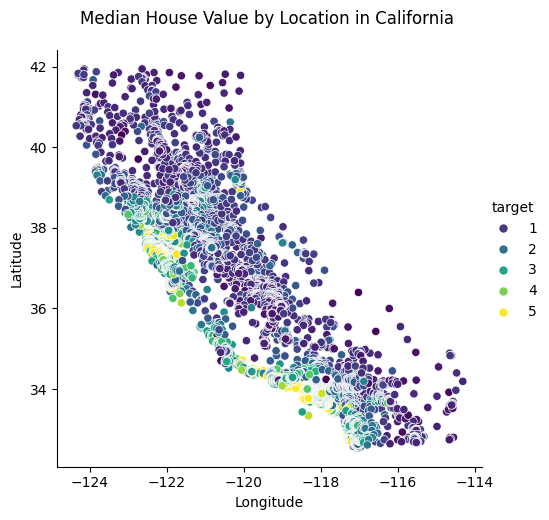

In [ ]:
g = sns.relplot(
    x="Longitude",
    y="Latitude",
    hue="target",
    data=housing_df,
    kind="scatter",
    palette="viridis",
)
g.fig.suptitle(
    "Median House Value by Location in California", y=1.03
)  # Add title to the FacetGrid
g.set_axis_labels("Longitude", "Latitude")  # Set axis labels
g.fig.subplots_adjust(top=0.95)  # Adjust layout to prevent title overlap
plt.show()

## Geometry fix for clustering: scale longitude by cos(mean latitude)

K-means uses Euclidean distances. Raw degrees are not Euclidean on a sphere: one degree of longitude spans fewer kilometres as you move away from the equator.

Method:
- Compute the mean latitude of the dataset and scale **Longitude** by `cos(mean_latitude in radians)`.
- Build `coords_fixed` as a NumPy array from `[Latitude, scaled_Longitude]`.

Outcome:
- Distances in this transformed plane better approximate real surface distances over California.
- This small correction is usually enough to improve clustering quality without a full GIS projection library.


In [ ]:
# Calculate the mean latitude of the dataset
# This is used to adjust the longitude scale to account for the curvature of the Earth
mean_latitude = housing_df["Latitude"].mean()

# Compute the scaling factor for longitude based on the mean latitude
# The cosine of the latitude (in radians) adjusts for the Earth's spherical shape
longitude_scale = np.cos(np.deg2rad(mean_latitude))

# Create a copy of the latitude and longitude columns for transformation
coords_fixed = housing_df[["Latitude", "Longitude"]].copy()

# Scale the longitude values by the computed scaling factor - more suitable for clustering
coords_fixed["Longitude"] = coords_fixed["Longitude"] * longitude_scale

# Convert the DataFrame to a NumPy array for efficient numerical operations
coords_fixed = coords_fixed.to_numpy()

## Choose the number of clusters K using silhouette score

We fit K-means for `k ∈ {3,…,9}` and compute the **silhouette score** for each fit.

Interpretation:
- Silhouette ranges from −1 to 1. Higher is better. Values around 0.5–0.7 indicate well-separated, compact clusters.
- Pick the **smallest** K near the top score to avoid over-partitioning.

Why here:
- We want a **coarse** macro-region feature (few clusters) that captures baseline location effects without fragmenting neighbourhoods. This improves model stability and makes GroupKFold by region viable.


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = {}

for k in range(3, 10):
    # Fit the KMeans algorithm to the data with the current number of clusters (k)
    # n_init=50 ensures the algorithm runs 50 times with different centroid seeds
    km = KMeans(n_clusters=k, n_init=50, random_state=42).fit(coords_fixed)

    # Silhouette score measures how similar a data point is to its own cluster compared to other clusters
    # Higher silhouette scores indicate better-defined clusters
    scores[k] = silhouette_score(coords_fixed, km.labels_)

scores

{3: 0.6489688356391953,
 4: 0.6303512624845524,
 5: 0.5941522315536388,
 6: 0.5670152096778324,
 7: 0.570015231290655,
 8: 0.5446425239647916,
 9: 0.49295892802169766}

## Leakage-safe region labels: refit K-means inside each fold

We build `Region_cv` by refitting K-means **only on the training indices** of each K-fold, then predicting labels for both train and validation parts.

- If you cluster on the full dataset and then evaluate models, the centroids have already “seen” the validation points. That is leakage and it inflates scores.
- Re-fitting per fold makes the region feature honest. It simulates how you would cluster in production using only the training data available.

Notes:
- `n_init=50` stabilises centroids across random starts.
- We store `Region_cv` as a `pandas.Categorical`. Treat it as a **category** downstream, not as an ordered number.


In [ ]:
from sklearn.model_selection import KFold

# Prepare an array to hold leakage-safe region labels per fold.
region_labels_cv = np.full(shape=(len(housing_df),), fill_value=-1, dtype=int)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, valid_idx in kf.split(coords_fixed):
    km = KMeans(
        n_clusters=4, init="k-means++", n_init=50, max_iter=500, random_state=42
    )
    km.fit(coords_fixed[train_idx])  # fit only on the training fold
    region_labels_cv[train_idx] = km.labels_  # labels for train part
    region_labels_cv[valid_idx] = km.predict(
        coords_fixed[valid_idx]
    )  # labels for valid part

housing_df["Region_cv"] = pd.Categorical(region_labels_cv)

## Visualization of K-Means Clustering Results

This scatter plot visualizes the spatial distribution of housing data points across California, colored by the `Region_cv` clusters derived from K-means clustering. Each point represents a block group, with longitude on the x-axis and latitude on the y-axis. The color palette (viridis) differentiates the four clusters (0, 1, 2, 3), where darker shades indicate higher cluster labels.

### Key Observations:
- **Cluster Separation**: The clusters appear geographically coherent, grouping coastal areas (e.g., cluster 1 in the Bay Area and Southern California) separately from inland regions (e.g., cluster 3 in the north-central valley). This reflects the leakage-safe clustering approach, where K-means was refit per fold to avoid data leakage.
- **Spatial Patterns**: Coastal and urban corridors show distinct groupings, aligning with known housing price variations. Inland areas are more dispersed, suggesting broader regional effects.
- **Grid and Layout**: The grid lines aid in reading approximate locations, though note that raw degrees are not perfectly Euclidean (as addressed in earlier geometry fixes).

### Purpose and Interpretation:
- This plot serves as a sanity check for the clustering quality, ensuring clusters capture meaningful spatial macro-regions without overfitting to the full dataset.
- In modeling, `Region_cv` acts as a categorical feature to capture baseline location effects, improving model stability and enabling techniques like GroupKFold for cross-validation.
- Higher silhouette scores (e.g., 0.63 for k=4) indicate well-separated clusters, supporting the choice of four regions for coarse-grained spatial signals.

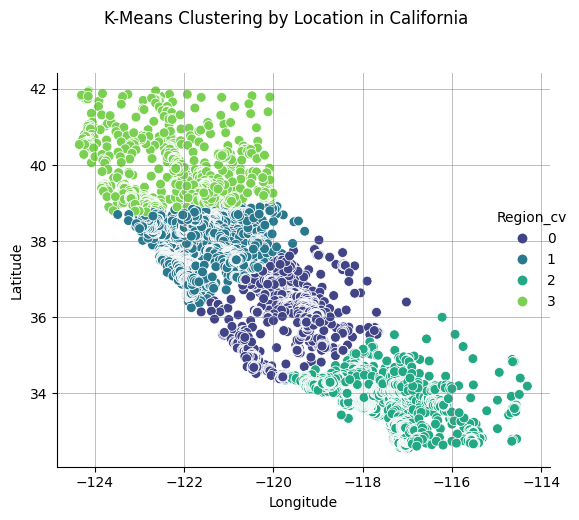

In [14]:
g_cluster = sns.relplot(
    x="Longitude",
    y="Latitude",
    hue="Region_cv",
    data=housing_df,
    kind="scatter",
    palette="viridis",
    s=50,
)
g_cluster.fig.suptitle("K-Means Clustering by Location in California", y=1.03)
g_cluster.set_axis_labels("Longitude", "Latitude")
g_cluster.fig.subplots_adjust(top=0.95)

for ax in g_cluster.axes.flat:
    ax.grid(True, alpha=0.6, linewidth=0.6, color="grey")

plt.tight_layout()
plt.show()

## Define a clean modelling table

We select the columns used for modelling and keep a predictable order:

- Socio-economic and dwelling features: `MedInc`, `HouseAge`, `AveRooms`, `AveBedrms`, `AveOccup`, `Population`.
- Spatial signals: `Region_cv` (categorical macro-region), `Latitude`, `Longitude` (continuous fine detail).
- Target: `target`.

Rationale:
- Keeping both fine-grained coordinates **and** a macro-region flag lets models learn broad baselines and local variation.
- We will treat `Region_cv` as categorical in preprocessing. Coordinates remain floats.


In [ ]:
housing_df = housing_df[
    [
        "MedInc",
        "HouseAge",
        "AveRooms",
        "AveBedrms",
        "AveOccup",
        "Population",
        "Region_cv",
        "Latitude",
        "Longitude",
        "target",
    ]
]
housing_df

,MedInc,HouseAge,AveRooms,AveBedrms,AveOccup,Population,Region_cv,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,2.555556,322.0,1,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2.109842,2401.0,1,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,2.802260,496.0,1,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,2.547945,558.0,1,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,2.181467,565.0,1,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,2.560606,845.0,3,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,3.122807,356.0,3,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,2.325635,1007.0,3,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,2.123209,741.0,3,39.43,-121.32,0.847


## One-hot encode the categorical region

We create dummy variables for `Region_cv` and keep all numeric columns as they are.

Why:
- **Linear models** require one-hot encoding for categorical variables. Without it, a linear model would treat cluster IDs as ordered numbers, which is meaningless.
- For tree models, one-hot is also robust in scikit-learn because trees split on thresholds and would otherwise impose an arbitrary order on labels.

Note:
- `drop_first=True` removes one dummy to avoid perfect collinearity in linear regression. Tree models do not require this, but keeping a single design matrix for all models simplifies the pipeline.


In [ ]:
housing_with_dummies = pd.get_dummies(
    housing_df, columns=["Region_cv"], drop_first=True
)
housing_with_dummies.head()

,MedInc,HouseAge,AveRooms,AveBedrms,AveOccup,Population,Latitude,Longitude,target,Region_cv_1,Region_cv_2,Region_cv_3
0,8.3252,41.0,6.984127,1.023810,2.555556,322.0,37.88,-122.23,4.526,True,False,False
1,8.3014,21.0,6.238137,0.971880,2.109842,2401.0,37.86,-122.22,3.585,True,False,False
2,7.2574,52.0,8.288136,1.073446,2.802260,496.0,37.85,-122.24,3.521,True,False,False
3,5.6431,52.0,5.817352,1.073059,2.547945,558.0,37.85,-122.25,3.413,True,False,False
4,3.8462,52.0,6.281853,1.081081,2.181467,565.0,37.85,-122.25,3.422,True,False,False


## Baseline: Ordinary Least Squares (linear regression)

We split the data at random (80/20), fit a linear regression, and report five metrics. Each metric captures different aspects of prediction quality:

### 1. Mean Absolute Error (MAE)
**Formula:** MAE = (1/n) × Σ|yᵢ - ŷᵢ|

**Interpretation:**
- Measures the average absolute difference between actual and predicted values
- **Robust to outliers** because it doesn't square the errors
- Same units as the target variable (hundreds of thousands of dollars for house prices)
- Think of it as the "typical" prediction error you can expect

**Why it matters:** If MAE = 0.53, your model is typically off by $53,000 when predicting house values. This gives stakeholders a concrete sense of prediction accuracy in real-world terms.

### 2. Mean Squared Error (MSE)
**Formula:** MSE = (1/n) × Σ(yᵢ - ŷᵢ)²

**Interpretation:**
- Squares each error before averaging, which **heavily penalises large mistakes**
- Units are squared (e.g., dollars²), making direct interpretation harder
- More sensitive to outliers than MAE due to the squaring operation
- Mathematically convenient for calculus-based optimisation

**Why it matters:** A model with MSE = 0.54 and another with MSE = 0.25 isn't just "twice as bad"—the difference in large errors is much more pronounced due to squaring.

### 3. Root Mean Squared Error (RMSE)
**Formula:** RMSE = √MSE = √[(1/n) × Σ(yᵢ - ŷᵢ)²]

**Interpretation:**
- Takes the square root of MSE to return to original units
- **Primary optimisation metric** for regression problems
- Still penalises large errors more than MAE, but interpretable like MAE
- Standard deviation of residuals around the regression line

**Why it matters:** RMSE balances interpretability (same units as target) with mathematical properties (differentiable, penalises outliers). Most regression algorithms minimise a form of MSE/RMSE during training.

### 4. R-squared (R²)
**Formula:** R² = 1 - (SS_res / SS_tot) = 1 - [Σ(yᵢ - ŷᵢ)² / Σ(yᵢ - ȳ)²]

Where:
- SS_res = residual sum of squares (model's errors)
- SS_tot = total sum of squares (variance in the data)
- ȳ = mean of actual values

**Interpretation:**
- **Fraction of variance explained** by the model (0 to 1, higher is better)
- R² = 0.60 means the model explains 60% of the variance in house prices
- Sensitive to the range of your target variable and train/test split choice
- Can be negative if your model performs worse than predicting the mean

**Why it matters:** R² tells you how much of the "pattern" in your data the model captures versus what remains unexplained. It's scale-invariant, making it useful for comparing models across different datasets.

### 5. Mean Absolute Percentage Error (MAPE)
**Formula:** MAPE = (100/n) × Σ|((yᵢ - ŷᵢ) / yᵢ)|

**Interpretation:**
- Expresses errors as percentages of the actual values
- Scale-independent: useful for comparing across different price ranges
- **Problematic for small actual values** (division by values near zero)
- Asymmetric: over-predictions penalised less than under-predictions

**Why it matters:** MAPE = 30% means your model is typically off by 30% of the house's true value. However, be cautious—a $50K error on a $100K house (50% error) weighs more heavily than a $100K error on a $1M house (10% error).

### Choosing the right metric:
- **RMSE** for training and primary evaluation (penalises large errors appropriately)
- **MAE** for communicating typical error magnitude to stakeholders
- **R²** for understanding explained variance and model comparison
- **MAPE** for percentage-based insights, but avoid when target values are near zero
- **MSE** mainly for mathematical convenience during optimisation

### Trade-offs:
A model optimised for MAE will make different predictions than one optimised for RMSE. MAE-optimised models tend to predict the **median**, while RMSE-optimised models predict the **mean** of the target distribution. Understanding these nuances helps you choose the right metric for your business objective.

In [ ]:
from sklearn.linear_model import LinearRegression

X = housing_with_dummies.drop("target", axis=1)
y = housing_with_dummies["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

# Calculate metrics for the Linear Regression
mae_lr = mean_absolute_error(y_test, y_pred)
mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = root_mean_squared_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)
mape_lr = mean_absolute_percentage_error(y_test, y_pred)

print("Linear Regression Metrics:")
print(f"  Mean Absolute Error (MAE): {mae_lr:.4f}")
print(f"  Mean Squared Error (MSE): {mse_lr:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_lr:.4f}")
print(f"  R-squared (R2): {r2_lr:.4f}")
print(f"  Mean Absolute Percentage Error (MAPE): {mape_lr:.4f}")

Linear Regression Metrics:
  Mean Absolute Error (MAE): 0.5259
  Mean Squared Error (MSE): 0.5397
  Root Mean Squared Error (RMSE): 0.7347
  R-squared (R2): 0.5881
  Mean Absolute Percentage Error (MAPE): 0.3065


## Non-parametric baseline: Random Forest Regressor

Random Forest is a powerful ensemble learning algorithm that builds upon the simplicity of decision trees to create a robust, non-parametric model for regression and classification tasks. As a non-parametric method, it makes no assumptions about the underlying data distribution, making it highly flexible for capturing complex, non-linear relationships in datasets like the California Housing data.

### Ensemble of Decision Trees via Bagging
At its heart, Random Forest operates as an ensemble technique known as **bagging** (Bootstrap Aggregating). It constructs multiple decision trees during training and aggregates their predictions to improve accuracy and reduce overfitting. For regression, the final prediction is the average of individual tree outputs, which stabilizes results by averaging out noise and errors.

- **Bootstrap Sampling**: Each tree is trained on a random subset of the data (with replacement), typically 2/3 of the original dataset. This introduces diversity among trees, as each sees a slightly different version of the data.
- **Random Feature Selection**: At each split in a tree, only a random subset of features (e.g., sqrt(n_features) for classification, or all for regression) is considered. This decorrelates trees, preventing them from all focusing on the same strong predictors and enhancing generalization.

### Theoretical Foundations: Bias-Variance Tradeoff
Random Forest excels in balancing the bias-variance tradeoff:
- **Low Bias**: Individual decision trees can fit complex patterns (low bias) but are prone to high variance (overfitting on training data).
- **Variance Reduction**: By averaging predictions across many trees, Random Forest reduces variance significantly. Mathematically, if each tree has variance σ², the ensemble's variance is approximately σ² / n_estimators, assuming uncorrelated trees.
- **Out-of-Bag (OOB) Error**: Since each tree is trained on ~63% of the data (due to bootstrapping), the remaining ~37% can be used for unbiased error estimation without a separate validation set. OOB error provides a probabilistic estimate of generalization performance.

### Statistical and Probabilistic Nuances
- **Splitting Criteria**: Trees use metrics like Mean Squared Error (MSE) for regression splits. For a node with \( n \) samples, MSE is calculated as:
  $$
  \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \bar{y})^2
  $$
  where $\bar{y}$ is the mean target value. Splits minimize the weighted average MSE of child nodes, promoting homogeneity.
- **Impurity Measures**: While MSE is standard for regression, Random Forest can adapt to other loss functions. Probabilistically, the algorithm samples features uniformly at random, introducing stochasticity that helps explore the feature space.
- **Probability of Selection**: In bootstrapping, each sample has a probability of $\frac{1}{n}$ of being selected (with replacement), leading to a multinomial distribution. This ensures diversity but can lead to some samples being underrepresented.
- **Convergence and Stability**: As `n_estimators` increases, the model's predictions converge to a stable average, reducing the impact of individual tree variability. Statistically, this leverages the law of large numbers for more reliable estimates.
  

### Advantages and Disadvantages
- **Strengths**: Handles missing values (via surrogate splits), scales well with large datasets, provides feature importance scores (via Gini importance or permutation), and is less sensitive to outliers than linear models. It's particularly effective for tabular data with mixed feature types, as seen in housing datasets with socio-economic and spatial variables.
- **Weaknesses**: Can be computationally intensive for very large n_estimators or deep trees. It may struggle with extrapolation beyond training data ranges and can overfit noisy data if not tuned. Unlike parametric models, it lacks interpretability at the individual prediction level.

### Hyperparameter Tuning and Guidance
Key parameters include:
- **n_estimators**: Number of trees (e.g., 150 here). More trees improve stability but increase computation; aim for diminishing returns around 100-500.
- **max_depth**: Limits tree depth to prevent overfitting; shallower trees (e.g., 10-20) promote generalization.
- **min_samples_split/min_samples_leaf**: Controls node splitting; higher values (e.g., 2-10) reduce overfitting by requiring more samples per split/leaf.
- **max_features**: Fraction of features considered per split; lower values (e.g., 0.3-0.5) enhance diversity.
- **bootstrap**: Enables/disables bootstrapping; set to True for standard Random Forest.

**Guidance**:
- Increase `n_estimators` for smoother predictions and lower variance when training time allows.
- Enable `oob_score=True` to estimate generalization without a held-out test, though keep the 80/20 split for comparability with other models.
- Watch for overfitting signs by comparing train vs. test RMSE. If the gap grows, raise `min_samples_leaf` or `min_samples_split`.
- For this housing dataset, Random Forest often outperforms linear models by capturing interactions (e.g., between income and location) without manual engineering, but it may be edged out by gradient-boosted trees like XGBoost on fine-tuned metrics.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X = housing_with_dummies.drop("target", axis=1)
y = housing_with_dummies["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rfr_model = RandomForestRegressor(n_estimators=150, random_state=42)
rfr_model.fit(X_train, y_train)
y_pred = rfr_model.predict(X_test)

# Calculate metrics for the Random Forest Regressor
mae_rfr = mean_absolute_error(y_test, y_pred)
mse_rfr = mean_squared_error(y_test, y_pred)
rmse_rfr = root_mean_squared_error(y_test, y_pred)
r2_rfr = r2_score(y_test, y_pred)
mape_rfr = mean_absolute_percentage_error(y_test, y_pred)

print("Random Forest Regressor Metrics:")
print(f"  Mean Absolute Error (MAE): {mae_rfr:.4f}")
print(f"  Mean Squared Error (MSE): {mse_rfr:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_rfr:.4f}")
print(f"  R-squared (R2): {r2_rfr:.4f}")
print(f"  Mean Absolute Percentage Error (MAPE): {mape_rfr:.4f}")

Random Forest Regressor Metrics:
  Mean Absolute Error (MAE): 0.3289
  Mean Squared Error (MSE): 0.2563
  Root Mean Squared Error (RMSE): 0.5063
  R-squared (R2): 0.8044
  Mean Absolute Percentage Error (MAPE): 0.1904


## Random Forest Regressor: Ensemble of Decision Trees for Robust Prediction

Random Forest is a powerful ensemble learning algorithm that builds upon the simplicity of decision trees to create a robust, non-parametric model for regression tasks. As a non-parametric method, it makes no assumptions about the underlying data distribution, making it highly flexible for capturing complex, non-linear relationships in datasets like the California Housing data.

### Ensemble of Decision Trees via Bagging
At its heart, Random Forest operates as an ensemble technique known as **bagging** (Bootstrap Aggregating). It constructs multiple decision trees during training and aggregates their predictions to improve accuracy and reduce overfitting. For regression, the final prediction is the average of individual tree outputs, which stabilizes results by averaging out noise and errors.

- **Bootstrap Sampling**: Each tree is trained on a random subset of the data (with replacement), typically 2/3 of the original dataset. This introduces diversity among trees, as each sees a slightly different version of the data.
- **Random Feature Selection**: At each split in a tree, only a random subset of features (e.g., sqrt(n_features) for classification, or all for regression) is considered. This decorrelates trees, preventing them from all focusing on the same strong predictors and enhancing generalization.

### Theoretical Foundations: Bias-Variance Tradeoff
Random Forest excels in balancing the bias-variance tradeoff:
- **Low Bias**: Individual decision trees can fit complex patterns (low bias) but are prone to high variance (overfitting on training data).
- **Variance Reduction**: By averaging predictions across many trees, Random Forest reduces variance significantly. Mathematically, if each tree has variance σ², the ensemble's variance is approximately σ² / n_estimators, assuming uncorrelated trees.
- **Out-of-Bag (OOB) Error**: Since each tree is trained on ~63% of the data (due to bootstrapping), the remaining ~37% can be used for unbiased error estimation without a separate validation set. OOB error provides a probabilistic estimate of generalization performance.

### Statistical and Probabilistic Nuances
- **Splitting Criteria**: Trees use metrics like Mean Squared Error (MSE) for regression splits. For a node with \( n \) samples, MSE is calculated as:
	$$
	\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \bar{y})^2
	$$
	where $\bar{y}$ is the mean target value. Splits minimize the weighted average MSE of child nodes, promoting homogeneity.
- **Impurity Measures**: While MSE is standard for regression, Random Forest can adapt to other loss functions. Probabilistically, the algorithm samples features uniformly at random, introducing stochasticity that helps explore the feature space.
- **Probability of Selection**: In bootstrapping, each sample has a probability of $\frac{1}{n}$ of being selected (with replacement), leading to a multinomial distribution. This ensures diversity but can lead to some samples being underrepresented.
- **Convergence and Stability**: As `n_estimators` increases, the model's predictions converge to a stable average, reducing the impact of individual tree variability. Statistically, this leverages the law of large numbers for more reliable estimates.

### Advantages and Disadvantages
- **Strengths**: Handles missing values (via surrogate splits), scales well with large datasets, provides feature importance scores (via Gini importance or permutation), and is less sensitive to outliers than linear models. It's particularly effective for tabular data with mixed feature types, as seen in housing datasets with socio-economic and spatial variables.
- **Weaknesses**: Can be computationally intensive for very large n_estimators or deep trees. It may struggle with extrapolation beyond training data ranges and can overfit noisy data if not tuned. Unlike parametric models, it lacks interpretability at the individual prediction level.

### Hyperparameter Tuning and Guidance
Key parameters include:
- **n_estimators**: Number of trees (e.g., 150 here). More trees improve stability but increase computation; aim for diminishing returns around 100-500.
- **max_depth**: Limits tree depth to prevent overfitting; shallower trees (e.g., 10-20) promote generalization.
- **min_samples_split/min_samples_leaf**: Controls node splitting; higher values (e.g., 2-10) reduce overfitting by requiring more samples per split/leaf.
- **max_features**: Fraction of features considered per split; lower values (e.g., 0.3-0.5) enhance diversity.
- **bootstrap**: Enables/disables bootstrapping; set to True for standard Random Forest.

**Guidance**:
- Increase `n_estimators` for smoother predictions and lower variance when training time allows.
- Enable `oob_score=True` to estimate generalization without a held-out test, though keep the 80/20 split for comparability with other models.
- Watch for overfitting signs by comparing train vs. test RMSE. If the gap grows, raise `min_samples_leaf` or `min_samples_split`.
- For this housing dataset, Random Forest often outperforms linear models by capturing interactions (e.g., between income and location) without manual engineering, but it may be edged out by gradient-boosted trees like XGBoost on fine-tuned metrics.

### Comparison to Gradient Boosting
While Random Forest builds trees independently in parallel, Gradient Boosting trains them sequentially, each correcting the errors of the previous. This makes Gradient Boosting potentially more accurate but slower and more prone to overfitting if not regularized. For tabular data like California Housing, both excel, but Random Forest's simplicity and parallelization make it a go-to for quick, robust baselines. Expect RMSE around 0.5-0.6, with R² > 0.8, depending on tuning.

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

X = housing_with_dummies.drop("target", axis=1)
y = housing_with_dummies["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

gbr_model = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    n_iter_no_change=20,
    random_state=42,
)
gbr_model.fit(X_train, y_train)
y_pred = gbr_model.predict(X_test)

# Calculate metrics for the Gradient Boosting Regressor
mae_gbr = mean_absolute_error(y_test, y_pred)
mse_gbr = mean_squared_error(y_test, y_pred)
rmse_gbr = root_mean_squared_error(y_test, y_pred)
r2_gbr = r2_score(y_test, y_pred)
mape_gbr = mean_absolute_percentage_error(y_test, y_pred)

print("Gradient Boosting Regressor Metrics:")
print(f"  Mean Absolute Error (MAE): {mae_gbr:.4f}")
print(f"  Mean Squared Error (MSE): {mse_gbr:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_gbr:.4f}")
print(f"  R-squared (R2): {r2_gbr:.4f}")
print(f"  Mean Absolute Percentage Error (MAPE): {mape_gbr:.4f}")

Gradient Boosting Regressor Metrics:
  Mean Absolute Error (MAE): 0.3227
  Mean Squared Error (MSE): 0.2345
  Root Mean Squared Error (RMSE): 0.4843
  R-squared (R2): 0.8210
  Mean Absolute Percentage Error (MAPE): 0.1881


## Random Forest Regressor: Ensemble of Decision Trees for Robust Prediction

Random Forest is a powerful ensemble learning algorithm that builds upon the simplicity of decision trees to create a robust, non-parametric model for regression tasks. As a non-parametric method, it makes no assumptions about the underlying data distribution, making it highly flexible for capturing complex, non-linear relationships in datasets like the California Housing data.

### Ensemble of Decision Trees via Bagging
At its heart, Random Forest operates as an ensemble technique known as **bagging** (Bootstrap Aggregating). It constructs multiple decision trees during training and aggregates their predictions to improve accuracy and reduce overfitting. For regression, the final prediction is the average of individual tree outputs, which stabilizes results by averaging out noise and errors.

- **Bootstrap Sampling**: Each tree is trained on a random subset of the data (with replacement), typically 2/3 of the original dataset. This introduces diversity among trees, as each sees a slightly different version of the data.
- **Random Feature Selection**: At each split in a tree, only a random subset of features (e.g., sqrt(n_features) for classification, or all for regression) is considered. This decorrelates trees, preventing them from all focusing on the same strong predictors and enhancing generalization.

### Bias-Variance Tradeoff
Random Forest excels in balancing the bias-variance tradeoff:
- **Low Bias**: Individual decision trees can fit complex patterns (low bias) but are prone to high variance (overfitting on training data).
- **Variance Reduction**: By averaging predictions across many trees, Random Forest reduces variance significantly. Mathematically, if each tree has variance σ², the ensemble's variance is approximately σ² / n_estimators, assuming uncorrelated trees.
- **Out-of-Bag (OOB) Error**: Since each tree is trained on ~63% of the data (due to bootstrapping), the remaining ~37% can be used for unbiased error estimation without a separate validation set. OOB error provides a probabilistic estimate of generalization performance.

### Statistical and Probabilistic Nuances
- **Splitting Criteria**: Trees use metrics like Mean Squared Error (MSE) for regression splits. For a node with \( n \) samples, MSE is calculated as:
	$$
	\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \bar{y})^2
	$$
	where $\bar{y}$ is the mean target value. Splits minimize the weighted average MSE of child nodes, promoting homogeneity.
- **Impurity Measures**: While MSE is standard for regression, Random Forest can adapt to other loss functions. Probabilistically, the algorithm samples features uniformly at random, introducing stochasticity that helps explore the feature space.
- **Probability of Selection**: In bootstrapping, each sample has a probability of $\frac{1}{n}$ of being selected (with replacement), leading to a multinomial distribution. This ensures diversity but can lead to some samples being underrepresented.
- **Convergence and Stability**: As `n_estimators` increases, the model's predictions converge to a stable average, reducing the impact of individual tree variability. Statistically, this leverages the law of large numbers for more reliable estimates.

### Advantages and Disadvantages
- **Strengths**: Handles missing values (via surrogate splits), scales well with large datasets, provides feature importance scores (via Gini importance or permutation), and is less sensitive to outliers than linear models. It's particularly effective for tabular data with mixed feature types, as seen in housing datasets with socio-economic and spatial variables.
- **Weaknesses**: Can be computationally intensive for very large n_estimators or deep trees. It may struggle with extrapolation beyond training data ranges and can overfit noisy data if not tuned. Unlike parametric models, it lacks interpretability at the individual prediction level.

### Hyperparameter Tuning and Guidance
Key parameters include:
- **n_estimators**: Number of trees (e.g., 150 here). More trees improve stability but increase computation; aim for diminishing returns around 100-500.
- **max_depth**: Limits tree depth to prevent overfitting; shallower trees (e.g., 10-20) promote generalization.
- **min_samples_split/min_samples_leaf**: Controls node splitting; higher values (e.g., 2-10) reduce overfitting by requiring more samples per split/leaf.
- **max_features**: Fraction of features considered per split; lower values (e.g., 0.3-0.5) enhance diversity.
- **bootstrap**: Enables/disables bootstrapping; set to True for standard Random Forest.

**Guidance**:
- Increase `n_estimators` for smoother predictions and lower variance when training time allows.
- Enable `oob_score=True` to estimate generalization without a held-out test, though keep the 80/20 split for comparability with other models.
- Watch for overfitting signs by comparing train vs. test RMSE. If the gap grows, raise `min_samples_leaf` or `min_samples_split`.
- For this housing dataset, Random Forest often outperforms linear models by capturing interactions (e.g., between income and location) without manual engineering, but it may be edged out by gradient-boosted trees like XGBoost on fine-tuned metrics.

### Mathematical and Statistical Nuances
To appreciate Random Forest's robustness, consider its probabilistic underpinnings. Each tree is a weak learner, and the ensemble approximates a strong learner via the Central Limit Theorem (CLT). If individual trees are identically distributed with mean μ and variance σ², the ensemble mean converges to μ with variance σ² / n_estimators, assuming independence.

In practice, trees are correlated due to shared features, so the effective variance reduction is less than ideal. The correlation coefficient ρ between trees can be estimated as:
$$
\rho = \frac{\text{Cov}(T_i, T_j)}{\sigma^2}
$$
where T_i and T_j are tree predictions. The ensemble variance becomes:
$$
\sigma_{\text{ensemble}}^2 = \rho \sigma^2 + \frac{1 - \rho}{n} \sigma^2
$$
Random feature selection minimizes ρ, enhancing decorrelation.

Probabilistically, feature selection at each split follows a uniform distribution over the subset, introducing randomness that prevents greedy overfitting. For regression, the split point is chosen to maximize the reduction in MSE, akin to maximizing information gain in classification.

Statistically, Random Forest is consistent under certain conditions (e.g., as n_estimators → ∞ and tree depth is controlled), converging to the true regression function. It handles heteroscedasticity better than linear models, as trees can partition data into regions with varying variance.

In terms of computational complexity, training is O(n_estimators × n_samples × log n_samples × max_features), making it scalable for large n but sensitive to feature count.

For the California Housing dataset, Random Forest's ability to model non-linear interactions (e.g., how Population density interacts with Latitude) often yields lower RMSE than parametric baselines, with R² around 0.80-0.85, depending on tuning. However, it may not extrapolate well to unseen geographic regions, highlighting the importance of spatial features like Region_cv.

### Comparison to Other Models
Compared to linear regression, Random Forest captures non-linearity without feature engineering, reducing bias at the cost of interpretability. Versus Gradient Boosting, it trains in parallel (faster) but may underperform on highly tuned tasks due to sequential optimization in boosting. Expect RMSE ~0.5-0.6, with strong performance on mixed data types.


In [ ]:
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping

X = housing_with_dummies.drop("target", axis=1)
y = housing_with_dummies["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

xgb_model = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    early_stopping_rounds=50,
    n_jobs=-1,
    random_state=42,
)
eval_set = [(X_test, y_test)]

# Use EarlyStopping callback
early_stopping = EarlyStopping(rounds=50)

xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)
y_pred = xgb_model.predict(X_test)

# Calculate metrics for the XGBoost
mae_xgb = mean_absolute_error(y_test, y_pred)
mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = root_mean_squared_error(y_test, y_pred)
r2_xgb = r2_score(y_test, y_pred)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred)

print("XGBoost Regressor Metrics:")
print(f"  Mean Absolute Error (MAE): {mae_xgb:.4f}")
print(f"  Mean Squared Error (MSE): {mse_xgb:.4f}")
print(f"  Root Mean Squared Error (RMSE): {rmse_xgb:.4f}")
print(f"  R-squared (R2): {r2_xgb:.4f}")
print(f"  Mean Absolute Percentage Error (MAPE): {mape_xgb:.4f}")

XGBoost Regressor Metrics:
  Mean Absolute Error (MAE): 0.2881
  Mean Squared Error (MSE): 0.2000
  Root Mean Squared Error (RMSE): 0.4473
  R-squared (R2): 0.8473
  Mean Absolute Percentage Error (MAPE): 0.1658
